In [1]:
# import all revelant packages
from headers import *
outputFolder = 'output'

## Setting parameters to match Emanuele

In [2]:
params = {
          'output': 'mPk,mTk',
          'P_k_max_h/Mpc': 100.,
          #'non linear' : 'HMCode',
          #'non linear' : 'halofit',
          'z_pk': '0.0,10',
          'A_s': 2.10732e-9,
          'n_s': 0.96824,
          'h': 0.6770,
          'omega_b': 0.02247,
          'omega_cdm': 0.11923}

cosmo = Class()
cosmo.set(params)
cosmo.compute()

The experiment has noise $N = 1000 \text{ [Mpc/h]}^3$, which corresponds to $n = 0.001 \text{ [h/Mpc]}^{3}$. I'm evaluating the power spectrum at $z=1$, so I choose to have one redshift bin centered about $1$. I'm setting the bias to $b=1.5$.

In [3]:
exp = experiment(zmin=0.8,zmax=1.2,n=1e-3,nbins=1,sigma_z=0.,b=1.5)

I'm marginalizing over the parameters $\Omega_b, \Omega_c, h, \log(A_s), n_s, b, \text{ and }N$. I'm setting $k_\text{min}=10^{-4}\text{ h/Mpc}$ and $k_\text{max} = 0.2\text{ h/Mpc}$. I'm splitting the integral up into 200 $k$ and $\mu$ bins.

In [4]:
fishcast = fisherForecast(experiment=exp,cosmo=cosmo,params=params,khmax=0.2,Nk=150,Nmu=150)
fishcast.marg_params = np.array(['omega_b','omega_cdm','h','log(A_s)','n_s','b','N'])

To be consistent with Emanuele, I'm setting the volume to be exactly  $22.2 \text{ [Gpc/h]}^3$.

In [5]:
fishcast.Vsurvey = np.array([2.22e10])

## Checking $\Delta b(k)$ with Simo

In [6]:
z=1.
pmatter = compute_matter_power_spectrum(fishcast, z)(fishcast.k)
D = 0.76 * fishcast.cosmo.scale_independent_growth_factor(z) # normalized so D(a) = a in the MD era
# hacky way of calculating the transfer function
T = np.sqrt(pmatter/fishcast.k**fishcast.params['n_s'])
T /= T[0]
fNL_factor = 3.*1.68*(1.5-1.)*fishcast.params['omega_cdm']*(100.*fishcast.params['h'])**2.
fNL_factor /= D * fishcast.k**2. * T * 299792.458**2.

In [7]:
delta_b = fishcast.get_f_at_fixed_mu(fNL_factor,0.)

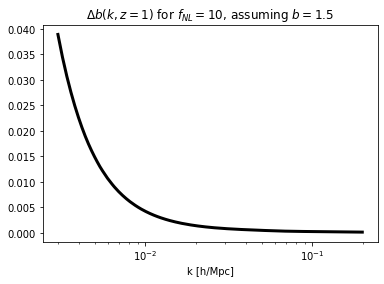

In [8]:
kk = np.linspace(3.e-3,0.199,1000)
plt.semilogx(kk,10.*delta_b(kk),c='k',lw=3)
plt.title(r'$\Delta b(k,z=1)$ for $f_{NL}=10$, assuming $b=1.5$')
plt.xlabel('k [h/Mpc]')
plt.savefig('output/delta_b.pdf',bbox_inches='tight')

In [9]:
from tabulate import tabulate
table = tabulate(np.transpose(np.array([kk,10.*delta_b(kk)])),['k [h/Mpc]', 'delta b'])
file = open(outputFolder+'/delta_b.dat','w')
file.write(table)
file.close()
print(table)

  k [h/Mpc]      delta b
-----------  -----------
 0.003       0.0389103
 0.0031962   0.0344133
 0.00339239  0.0306996
 0.00358859  0.0275885
 0.00378478  0.0249339
 0.00398098  0.0226523
 0.00417718  0.0206761
 0.00437337  0.0189509
 0.00456957  0.0174522
 0.00476577  0.0161436
 0.00496196  0.0149774
 0.00515816  0.0139294
 0.00535435  0.0129803
 0.00555055  0.0121586
 0.00574675  0.0114072
 0.00594294  0.0107111
 0.00613914  0.010102
 0.00633534  0.00953818
 0.00653153  0.00901365
 0.00672773  0.00855253
 0.00692392  0.0081084
 0.00712012  0.00771908
 0.00731632  0.00734499
 0.00751251  0.0070095
 0.00770871  0.00669004
 0.0079049   0.00640086
 0.0081011   0.00612395
 0.0082973   0.00587463
 0.00849349  0.0056309
 0.00868969  0.00541588
 0.00888589  0.00520086
 0.00908208  0.00501263
 0.00927828  0.00482718
 0.00947447  0.00465524
 0.00967067  0.00449526
 0.00986687  0.00433596
 0.0100631   0.00419791
 0.0102593   0.00405986
 0.0104555   0.00392938
 0.0106517   0.00381022
 0.0108478 

## Calculating power spectra and derivatives

In [10]:
# Derivatives of the matter power spectrum at z=0
data = np.genfromtxt(outputFolder+'/derivatives_dark_matter_z0p0_PlanckBAO.dat')
EmanK_matter_0 = np.array([data[i][0] for i in range(len(data))])
Eman_dPdomega_b_matter_0 = np.array([data[i][1] for i in range(len(data))])
Eman_dPdomega_b_matter_0 = interp1d(EmanK_matter_0,Eman_dPdomega_b_matter_0,kind='linear')
Eman_dPdomega_cdm_matter_0 = np.array([data[i][2] for i in range(len(data))])
Eman_dPdomega_cdm_matter_0 = interp1d(EmanK_matter_0,Eman_dPdomega_cdm_matter_0,kind='linear')
Eman_dPdh_matter_0 = np.array([data[i][3] for i in range(len(data))])
Eman_dPdh_matter_0 = interp1d(EmanK_matter_0,Eman_dPdh_matter_0,kind='linear')
Eman_p_fid_matter_0 = np.array([data[i][4] for i in range(len(data))])
Eman_p_fid_matter_0 = interp1d(EmanK_matter_0,Eman_p_fid_matter_0,kind='linear')
Eman_dPdn_s_matter_0 = np.array([data[i][5] for i in range(len(data))])
Eman_dPdn_s_matter_0 = interp1d(EmanK_matter_0,Eman_dPdn_s_matter_0,kind='linear')

# Fiducial galaxy power spectrum at z=1,mu=0
data = np.genfromtxt(outputFolder+'/Pgg_mu0p0_z1p0_b1p5_PlanckBAO18.dat')
EmanK_galaxy_1 = np.array([data[i][0] for i in range(len(data))])
# scaled by b^2 
Eman_p_fid_galaxy_1 = np.array([data[i][1] for i in range(len(data))]) * 2.25
Eman_p_fid_galaxy_1 = interp1d(EmanK_galaxy_1,Eman_p_fid_galaxy_1,kind='linear')

# Derivatives of the galay power spectrum at z=1,mu=0
data = np.genfromtxt(outputFolder+'/derivatives_mu0p0_z1p0_b1p5_N1e3_V22p2e9_PlanckBAO18_kmax0p2.dat')
EmanK_galaxy_1_0 = np.array([data[i][0] for i in range(len(data))])
Eman_dlnPdomega_b_galaxy_1_0  = np.array([data[i][1] for i in range(len(data))])
Eman_dlnPdomega_b_galaxy_1_0 = interp1d(EmanK_galaxy_1_0,Eman_dlnPdomega_b_galaxy_1_0,kind='linear')
Eman_dlnPdomega_cdm_galaxy_1_0  = np.array([data[i][2] for i in range(len(data))])
Eman_dlnPdomega_cdm_galaxy_1_0  = interp1d(EmanK_galaxy_1_0,Eman_dlnPdomega_cdm_galaxy_1_0 ,kind='linear')
Eman_dlnPdh_galaxy_1_0  = np.array([data[i][3] for i in range(len(data))])
Eman_dlnPdh_galaxy_1_0 = interp1d(EmanK_galaxy_1_0,Eman_dlnPdh_galaxy_1_0,kind='linear')
Eman_dlnPdlogA_s_galaxy_1_0 = np.array([data[i][4] for i in range(len(data))])
Eman_dlnPdlogA_s_galaxy_1_0 = interp1d(EmanK_galaxy_1_0,Eman_dlnPdlogA_s_galaxy_1_0,kind='linear')
Eman_dlnPdn_s_galaxy_1_0  = np.array([data[i][5] for i in range(len(data))])
Eman_dlnPdn_s_galaxy_1_0 = interp1d(EmanK_galaxy_1_0,Eman_dlnPdn_s_galaxy_1_0,kind='linear')

# Derivatives of the galay power spectrum at z=1,mu=0.5
data = np.genfromtxt(outputFolder+'/derivatives_mu0p5_z1p0_b1p5_N1e3_V22p2e9_PlanckBAO18_kmax0p2.dat')
EmanK_galaxy_1_5 = np.array([data[i][0] for i in range(len(data))])
Eman_dlnPdomega_b_galaxy_1_5  = np.array([data[i][1] for i in range(len(data))])
Eman_dlnPdomega_b_galaxy_1_5 = interp1d(EmanK_galaxy_1_5,Eman_dlnPdomega_b_galaxy_1_5,kind='linear')
Eman_dlnPdomega_cdm_galaxy_1_5  = np.array([data[i][2] for i in range(len(data))])
Eman_dlnPdomega_cdm_galaxy_1_5  = interp1d(EmanK_galaxy_1_5,Eman_dlnPdomega_cdm_galaxy_1_5 ,kind='linear')
Eman_dlnPdh_galaxy_1_5  = np.array([data[i][3] for i in range(len(data))])
Eman_dlnPdh_galaxy_1_5 = interp1d(EmanK_galaxy_1_5,Eman_dlnPdh_galaxy_1_5,kind='linear')
Eman_dlnPdlogA_s_galaxy_1_5 = np.array([data[i][4] for i in range(len(data))])
Eman_dlnPdlogA_s_galaxy_1_5 = interp1d(EmanK_galaxy_1_5,Eman_dlnPdlogA_s_galaxy_1_5,kind='linear')
Eman_dlnPdn_s_galaxy_1_5  = np.array([data[i][5] for i in range(len(data))])
Eman_dlnPdn_s_galaxy_1_5 = interp1d(EmanK_galaxy_1_5,Eman_dlnPdn_s_galaxy_1_5,kind='linear')

# Derivatives of the galay power spectrum at z=1,mu=1
data = np.genfromtxt(outputFolder+'/derivatives_mu1p0_z1p0_b1p5_N1e3_V22p2e9_PlanckBAO18_kmax0p2.dat')
EmanK_galaxy_1_1 = np.array([data[i][0] for i in range(len(data))])
Eman_dlnPdomega_b_galaxy_1_1  = np.array([data[i][1] for i in range(len(data))])
Eman_dlnPdomega_b_galaxy_1_1 = interp1d(EmanK_galaxy_1_1,Eman_dlnPdomega_b_galaxy_1_1,kind='linear')
Eman_dlnPdomega_cdm_galaxy_1_1  = np.array([data[i][2] for i in range(len(data))])
Eman_dlnPdomega_cdm_galaxy_1_1  = interp1d(EmanK_galaxy_1_1,Eman_dlnPdomega_cdm_galaxy_1_1 ,kind='linear')
Eman_dlnPdh_galaxy_1_1  = np.array([data[i][3] for i in range(len(data))])
Eman_dlnPdh_galaxy_1_1 = interp1d(EmanK_galaxy_1_1,Eman_dlnPdh_galaxy_1_1,kind='linear')
Eman_dlnPdlogA_s_galaxy_1_1 = np.array([data[i][4] for i in range(len(data))])
Eman_dlnPdlogA_s_galaxy_1_1 = interp1d(EmanK_galaxy_1_1,Eman_dlnPdlogA_s_galaxy_1_1,kind='linear')
Eman_dlnPdn_s_galaxy_1_1  = np.array([data[i][5] for i in range(len(data))])
Eman_dlnPdn_s_galaxy_1_1 = interp1d(EmanK_galaxy_1_1,Eman_dlnPdn_s_galaxy_1_1,kind='linear')

In [11]:
# Derivatives of the matter power spectrum at z=0
Noah_dPdomega_b_matter_0 = fishcast.compute_dPdp('omega_b',0.,five_point=True)/(1.5**2.)
Noah_dPdomega_b_matter_0 = fishcast.get_f_at_fixed_mu(Noah_dPdomega_b_matter_0,0.)
Noah_dPdomega_cdm_matter_0 = fishcast.compute_dPdp('omega_cdm',0.,five_point=True)/(1.5**2.)
Noah_dPdomega_cdm_matter_0 = fishcast.get_f_at_fixed_mu(Noah_dPdomega_cdm_matter_0,0.)
Noah_dPdh_matter_0 = fishcast.compute_dPdp('h',0.,five_point=True)/(1.5**2.)
Noah_dPdh_matter_0 = fishcast.get_f_at_fixed_mu(Noah_dPdh_matter_0,0.)
Noah_p_fid_matter_0 = fishcast.compute_dPdp('log(A_s)',0.,five_point=True)/(1.5**2.)
Noah_p_fid_matter_0 = fishcast.get_f_at_fixed_mu(Noah_p_fid_matter_0,0.)
Noah_dPdn_s_matter_0 = fishcast.compute_dPdp('n_s',0.,five_point=True)/(1.5**2.)
Noah_dPdn_s_matter_0 = fishcast.get_f_at_fixed_mu(Noah_dPdn_s_matter_0,0.)

# Fiducial matter power spectrum at z=1
Noah_p_fid_matter_1 = fishcast.compute_dPdp('log(A_s)',1.,five_point=True)/(1.5**2.)
Noah_p_fid_matter_1 = fishcast.get_f_at_fixed_mu(Noah_p_fid_matter_1,0.)

# Derivatives of the galaxy power spectrum at z=0,mu=0
Noah_dPdomega_b_galaxy_0 = lambda k: Noah_dPdomega_b_matter_0(k) * (1.5)**2.
Noah_dPdomega_cdm_galaxy_0 = lambda k: Noah_dPdh_matter_0(k) * (1.5)**2.
Noah_dPdh_galaxy_0 = lambda k: Noah_dPdh_matter_0(k) * (1.5)**2.
Noah_p_fid_galaxy_0 = lambda k: Noah_p_fid_matter_0(k) * (1.5)**2.
Noah_dPdn_s_galaxy_0 = lambda k: Noah_dPdn_s_matter_0(k) * (1.5)**2.

# Derivatives of the galaxy power spectrum at z=1
Noah_dPdomega_b_galaxy_1_brute = fishcast.compute_dPdp('omega_b',1.,five_point=True)
Noah_dPdomega_cdm_galaxy_1_brute = fishcast.compute_dPdp('omega_cdm',1.,five_point=True)
Noah_dPdh_galaxy_1_brute = fishcast.compute_dPdp('h',1.,five_point=True)
Noah_p_fid_galaxy_1 = fishcast.compute_dPdp('log(A_s)',1.,five_point=True)
Noah_dPdn_s_galaxy_1_brute = fishcast.compute_dPdp('n_s',1.,five_point=True)
# mu=0
Noah_dPdomega_b_galaxy_1_0_brute = fishcast.get_f_at_fixed_mu(Noah_dPdomega_b_galaxy_1_brute,0.)
Noah_dPdomega_cdm_galaxy_1_0_brute = fishcast.get_f_at_fixed_mu(Noah_dPdomega_cdm_galaxy_1_brute,0.)
Noah_dPdh_galaxy_1_0_brute = fishcast.get_f_at_fixed_mu(Noah_dPdh_galaxy_1_brute,0.)
Noah_p_fid_galaxy_1_0 = fishcast.get_f_at_fixed_mu(Noah_p_fid_galaxy_1,0.)
Noah_dPdn_s_galaxy_1_0_brute = fishcast.get_f_at_fixed_mu(Noah_dPdn_s_galaxy_1_brute,0.)
# mu=0.5
Noah_dPdomega_b_galaxy_1_5_brute = fishcast.get_f_at_fixed_mu(Noah_dPdomega_b_galaxy_1_brute,.5)
Noah_dPdomega_cdm_galaxy_1_5_brute = fishcast.get_f_at_fixed_mu(Noah_dPdomega_cdm_galaxy_1_brute,.5)
Noah_dPdh_galaxy_1_5_brute = fishcast.get_f_at_fixed_mu(Noah_dPdh_galaxy_1_brute,.5)
Noah_p_fid_galaxy_1_5 = fishcast.get_f_at_fixed_mu(Noah_p_fid_galaxy_1,.5)
Noah_dPdn_s_galaxy_1_5_brute = fishcast.get_f_at_fixed_mu(Noah_dPdn_s_galaxy_1_brute,.5)
# mu=1.
Noah_dPdomega_b_galaxy_1_1_brute = fishcast.get_f_at_fixed_mu(Noah_dPdomega_b_galaxy_1_brute,1.)
Noah_dPdomega_cdm_galaxy_1_1_brute = fishcast.get_f_at_fixed_mu(Noah_dPdomega_cdm_galaxy_1_brute,1.)
Noah_dPdh_galaxy_1_1_brute = fishcast.get_f_at_fixed_mu(Noah_dPdh_galaxy_1_brute,1.)
Noah_p_fid_galaxy_1_1 = fishcast.get_f_at_fixed_mu(Noah_p_fid_galaxy_1,1.)
Noah_dPdn_s_galaxy_1_1_brute = fishcast.get_f_at_fixed_mu(Noah_dPdn_s_galaxy_1_brute,1.)

## Matter power spectrum at z=0

They agree!

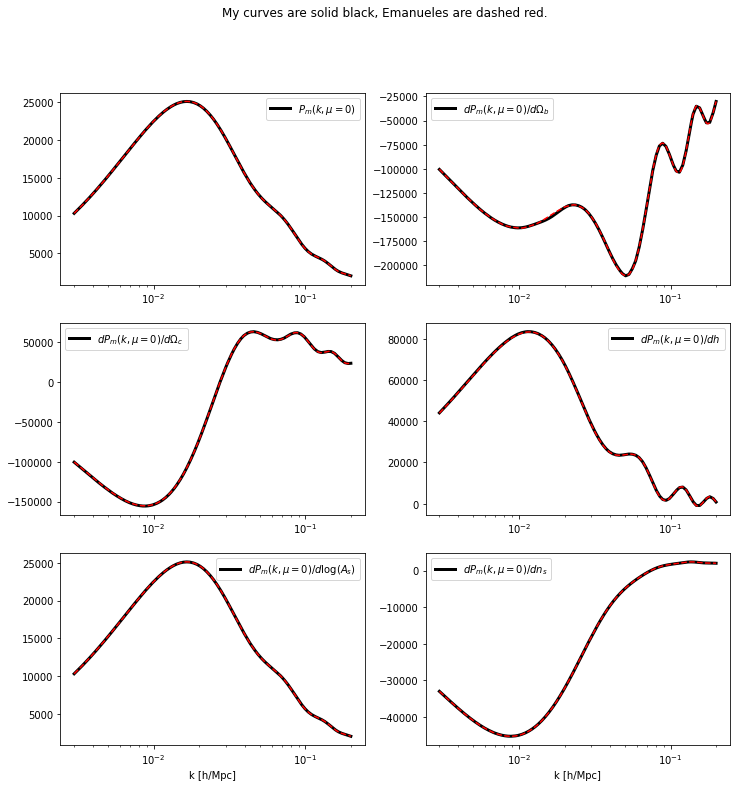

In [12]:
kk = np.linspace(3.e-3,0.199,1000)

fig, axs = plt.subplots(3, 2,figsize=(12,12))
axs[0,0].semilogx(kk,Noah_p_fid_matter_0(kk),c='k',label=r'$P_m(k,\mu=0)$',lw=3.)
axs[0,0].semilogx(kk,Eman_p_fid_matter_0(kk),c='r',ls='--')

axs[0,1].semilogx(kk,Noah_dPdomega_b_matter_0(kk),c='k',label=r'$dP_m(k,\mu=0)/d\Omega_b$',lw=3.)
axs[0,1].semilogx(kk,Eman_dPdomega_b_matter_0(kk),c='r',ls='--')

axs[1,0].semilogx(kk,Noah_dPdomega_cdm_matter_0(kk),c='k',label=r'$dP_m(k,\mu=0)/d\Omega_c$',lw=3.)
axs[1,0].semilogx(kk,Eman_dPdomega_cdm_matter_0(kk),c='r',ls='--')

axs[1,1].semilogx(kk,Noah_dPdh_matter_0(kk),c='k',label=r'$dP_m(k,\mu=0)/dh$',lw=3.)
axs[1,1].semilogx(kk,Eman_dPdh_matter_0(kk),c='r',ls='--')

axs[2,0].semilogx(kk,Noah_p_fid_matter_0(kk),c='k',label=r'$dP_m(k,\mu=0)/d\log(A_s)$',lw=3.)
axs[2,0].semilogx(kk,Eman_p_fid_matter_0(kk),c='r',ls='--')

axs[2,1].semilogx(kk,Noah_dPdn_s_matter_0(kk),c='k',label=r'$dP_m(k,\mu=0)/dn_s$',lw=3.)
axs[2,1].semilogx(kk,Eman_dPdn_s_matter_0(kk),c='r',ls='--')

axs[0,0].legend(loc=0.)
axs[0,1].legend(loc=0.)
axs[1,0].legend(loc=0.)
axs[1,1].legend(loc=0.)
axs[2,0].legend(loc=0.)
axs[2,1].legend(loc=0.)

axs[2,0].set_xlabel('k [h/Mpc]')
axs[2,1].set_xlabel('k [h/Mpc]')

fig.suptitle(r'My curves are solid black, Emanueles are dashed red.')
plt.savefig('output/matter_power_spectrum_z0.pdf')

## Galaxy power spectrum at z=1

They agree!

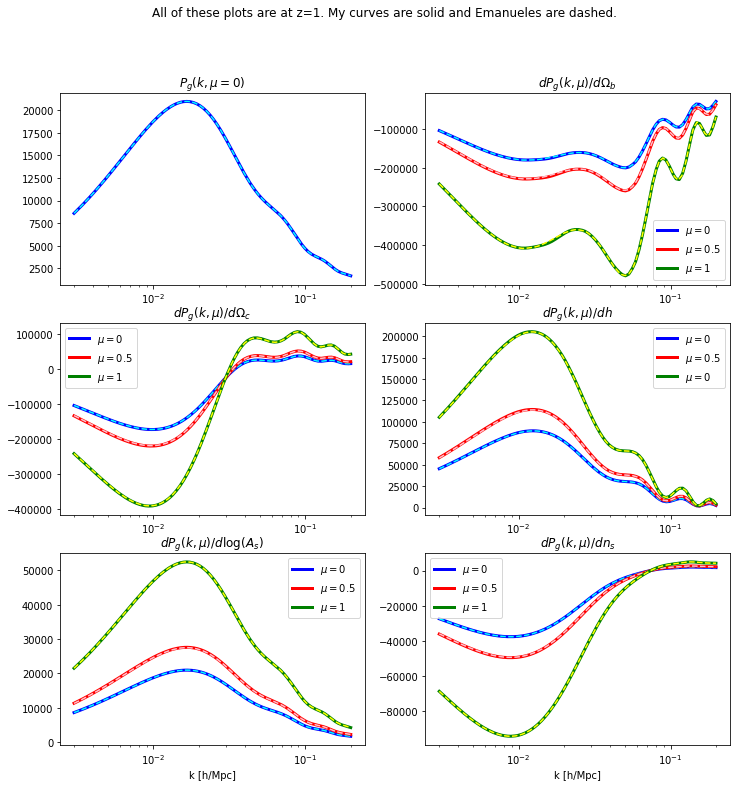

In [13]:
fig, axs = plt.subplots(3, 2,figsize=(12,12))
axs[0,0].semilogx(kk,Noah_p_fid_galaxy_1_0(kk),c='b',lw=3.)
axs[0,0].semilogx(kk,Eman_p_fid_galaxy_1(kk),c='cyan',ls='--')
axs[0,0].set_title(r'$P_g(k,\mu=0)$')

axs[0,1].semilogx(kk,Noah_dPdomega_b_galaxy_1_0_brute(kk),c='b',lw=3.,label=r'$\mu=0$')
axs[0,1].semilogx(kk,Eman_dlnPdomega_b_galaxy_1_0(kk)*Eman_p_fid_galaxy_1(kk),c='cyan',ls='--')
axs[0,1].semilogx(kk,Noah_dPdomega_b_galaxy_1_5_brute(kk),c='r',lw=3.,label=r'$\mu=0.5$')
axs[0,1].semilogx(kk,Eman_dlnPdomega_b_galaxy_1_5(kk),c='pink',ls='--')
axs[0,1].semilogx(kk,Noah_dPdomega_b_galaxy_1_1_brute(kk),c='g',lw=3.,label=r'$\mu=1$')
axs[0,1].semilogx(kk,Eman_dlnPdomega_b_galaxy_1_1(kk),c='yellow',ls='--')
axs[0,1].set_title(r'$dP_g(k,\mu)/d\Omega_b$')

axs[1,0].semilogx(kk,Noah_dPdomega_cdm_galaxy_1_0_brute(kk),c='b',lw=3.,label=r'$\mu=0$')
axs[1,0].semilogx(kk,Eman_dlnPdomega_cdm_galaxy_1_0(kk)*Eman_p_fid_galaxy_1(kk),c='cyan',ls='--')
axs[1,0].semilogx(kk,Noah_dPdomega_cdm_galaxy_1_5_brute(kk),c='r',lw=3.,label=r'$\mu=0.5$')
axs[1,0].semilogx(kk,Eman_dlnPdomega_cdm_galaxy_1_5(kk),c='pink',ls='--')
axs[1,0].semilogx(kk,Noah_dPdomega_cdm_galaxy_1_1_brute(kk),c='g',lw=3.,label=r'$\mu=1$')
axs[1,0].semilogx(kk,Eman_dlnPdomega_cdm_galaxy_1_1(kk),c='yellow',ls='--')
axs[1,0].set_title(r'$dP_g(k,\mu)/d\Omega_c$')

axs[1,1].semilogx(kk,Noah_dPdh_galaxy_1_0_brute(kk),c='b',lw=3.,label=r'$\mu=0$')
axs[1,1].semilogx(kk,Eman_dlnPdh_galaxy_1_0(kk)*Eman_p_fid_galaxy_1(kk),c='cyan',ls='--')
axs[1,1].semilogx(kk,Noah_dPdh_galaxy_1_5_brute(kk),c='r',lw=3.,label=r'$\mu=0.5$')
axs[1,1].semilogx(kk,Eman_dlnPdh_galaxy_1_5(kk),c='pink',ls='--')
axs[1,1].semilogx(kk,Noah_dPdh_galaxy_1_1_brute(kk),c='g',lw=3.,label=r'$\mu=0$')
axs[1,1].semilogx(kk,Eman_dlnPdh_galaxy_1_1(kk),c='yellow',ls='--')
axs[1,1].set_title(r'$dP_g(k,\mu)/dh$')

axs[2,0].semilogx(kk,Noah_p_fid_galaxy_1_0(kk),c='b',lw=3.,label=r'$\mu=0$')
axs[2,0].semilogx(kk,Eman_dlnPdlogA_s_galaxy_1_0(kk)*Eman_p_fid_galaxy_1(kk),c='cyan',ls='--')
axs[2,0].semilogx(kk,Noah_p_fid_galaxy_1_5(kk),c='r',lw=3.,label=r'$\mu=0.5$')
axs[2,0].semilogx(kk,Eman_dlnPdlogA_s_galaxy_1_5(kk),c='pink',ls='--')
axs[2,0].semilogx(kk,Noah_p_fid_galaxy_1_1(kk),c='g',lw=3.,label=r'$\mu=1$')
axs[2,0].semilogx(kk,Eman_dlnPdlogA_s_galaxy_1_1(kk),c='yellow',ls='--')
axs[2,0].set_title(r'$dP_g(k,\mu)/d\log(A_s)$')

axs[2,1].semilogx(kk,Noah_dPdn_s_galaxy_1_0_brute(kk),c='b',lw=3.,label=r'$\mu=0$')
axs[2,1].semilogx(kk,Eman_dlnPdn_s_galaxy_1_0(kk)*Eman_p_fid_galaxy_1(kk),c='cyan',ls='--')
axs[2,1].semilogx(kk,Noah_dPdn_s_galaxy_1_5_brute(kk),c='r',lw=3.,label=r'$\mu=0.5$')
axs[2,1].semilogx(kk,Eman_dlnPdn_s_galaxy_1_5(kk),c='pink',ls='--')
axs[2,1].semilogx(kk,Noah_dPdn_s_galaxy_1_1_brute(kk),c='g',lw=3.,label=r'$\mu=1$')
axs[2,1].semilogx(kk,Eman_dlnPdn_s_galaxy_1_1(kk),c='yellow',ls='--')

axs[2,1].set_title(r'$dP_g(k,\mu)/dn_s$')

axs[0,1].legend(loc=0.)
axs[1,0].legend(loc=0.)
axs[1,1].legend(loc=0.)
axs[2,0].legend(loc=0.)
axs[2,1].legend(loc=0.)

axs[2,0].set_xlabel('k [h/Mpc]')
axs[2,1].set_xlabel('k [h/Mpc]')

fig.suptitle('All of these plots are at z=1. My curves are solid and Emanueles are dashed.')
plt.savefig('output/galaxy_power_spectrum_z1.pdf')

## Comparing covariances

In [14]:
from twoPointNoise import*

In [15]:
c = compute_covariance_matrix(fishcast, 0)
c = 1./np.diag(c)
c_0 = fishcast.get_f_at_fixed_mu(c/(fishcast.dk*fishcast.dmu),0.)

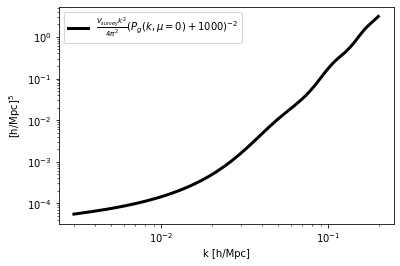

In [16]:
plt.loglog(kk,c_0(kk),label=r'$\frac{V_{survey} k^2}{4\pi^2}(P_g(k,\mu=0)+1000)^{-2}$',c='k',lw=3)
plt.legend(loc=0)
plt.xlabel('k [h/Mpc]')
plt.ylabel(r'[h/Mpc]$^5$')
plt.savefig('output/covariance.pdf')

In [17]:
from tabulate import tabulate
table = tabulate(np.transpose(np.array([kk,c_0(kk)])),['k [h/Mpc]', 'inverse covariance [h/Mpc]^5'])
file = open(outputFolder+'/inverse covariance.dat','w')
file.write(table)
file.close()
print(table)

  k [h/Mpc]    inverse covariance [h/Mpc]^5
-----------  ------------------------------
 0.003                          5.50637e-05
 0.0031962                      5.69859e-05
 0.00339239                     5.89041e-05
 0.00358859                     6.08259e-05
 0.00378478                     6.27574e-05
 0.00398098                     6.47033e-05
 0.00417718                     6.66664e-05
 0.00437337                     6.86494e-05
 0.00456957                     7.06585e-05
 0.00476577                     7.26985e-05
 0.00496196                     7.47687e-05
 0.00515816                     7.6869e-05
 0.00535435                     7.8998e-05
 0.00555055                     8.11755e-05
 0.00574675                     8.33889e-05
 0.00594294                     8.56321e-05
 0.00613914                     8.79333e-05
 0.00633534                     9.02732e-05
 0.00653153                     9.26466e-05
 0.00672773                     9.50895e-05
 0.00692392                     9.

## Comparing Fisher matrices

In [18]:
F = fishcast.compute_Fisher_matrix()

This is the Fisher matrix that Emanuele gets.

In [19]:
G = np.genfromtxt(outputFolder+'/Fisher_z1p0_b1p5_N1e3_V22p2e9_PlanckBAO18_kmax0p2.dat')

And here's the ratio of our forecasts.

In [20]:
headers = list(fishcast.marg_params.copy())
table = tabulate(G/F,headers)
file = open(outputFolder+'/Fisher_ratio.dat','w')
file.write(table)
file.close()

print(table)

  omega_b    omega_cdm        h    log(A_s)      n_s        b        N
---------  -----------  -------  ----------  -------  -------  -------
  1.56719      1.54673  1.56097     1.53049  1.6104   1.55595  2.06192
  1.54673      1.50506  1.56376     1.50787  1.53869  1.5348   1.62659
  1.56097      1.56376  1.53254     1.5211   1.67117  1.54396  2.23513
  1.53049      1.50787  1.5211      1.49011  1.57055  1.5145   1.67891
  1.6104       1.53869  1.67117     1.57055  1.54546  1.60111  1.7347
  1.55595      1.5348   1.54396     1.5145   1.60111  1.53717  1.69754
  2.06192      1.62659  2.23513     1.67891  1.7347   1.69754  1.7918


### Checking self-consistency 

In [21]:
np.sum(Noah_dPdomega_cdm_galaxy_1_brute**2.*c)/F[1,1]

0.9997707682831461